In [1]:
pwd

'/home/mtech/2020/satyaki_ghosh/codes/vulnerability_camera'

In [2]:
# SET WHICH GPU TO USE

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# import notebook_util
# notebook_util.pick_gpu_lowest_memory()
# import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17225323618674102400
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13318138779677625961
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 17395469517
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4454734710479415636
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:37:00.0, compute capability: 7.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14788324112341259355
physical_device_desc: "device: XLA_GPU device"
]


## CAMERA-MODEL IDENTIFICATION

### DENSENET

In [1]:
import numpy as np
import os
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,LearningRateScheduler
import pickle
import math
import matplotlib.pyplot as plt

import sys 
import os
sys.path.append(os.path.abspath("/home/mtech/2020/satyaki_ghosh/codes/vulnerability_camera/DenseNet"))
import densenet



IMG_SIZE = 224
channels = 3
image_dim = (IMG_SIZE, IMG_SIZE, 3)

Using TensorFlow backend.


In [3]:
# LOADING THE DATSET
with open('/home/mtech/2020/satyaki_ghosh/codes/fastAdvTraining/fast_adversarial/VISION/training_data.npy','rb') as f:
    dummy = np.load(f, allow_pickle=True)
dataset = list(dummy)

# TRAIN-TEST SPLIT AND SHUFFLE THE PATCHES : (train,val,test) = (0.8,0.1,0.1)
random.shuffle(dataset)
split_ratio = 0.8
split_num = int(len(dataset) * split_ratio)
print(type(split_num))
print(split_num)

<class 'int'>
60000


In [4]:
# CREATING INPUT AND LABELS
X = []
for features,_ in dataset :
  X.append(features)

X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,channels)

In [6]:
# MEAN AND STD REQUIRED FOR FAST ADVERSARIAL TRAINING

print(X.reshape(-1,3).mean(axis=0))
print(X.reshape(-1,3).std(axis=0))

[110.50732137 118.19133075 121.56344018]
[68.52877977 64.68004537 66.13338036]


In [5]:
# CREATING TRAINING DATA
training_data = dataset[0:split_num]

# CREATING INPUT AND LABELS
X = []
Y = []
for features,label in training_data :
  X.append(features)
  Y.append(label)
    
    
# PREPROCESSING
print(X[0].shape)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,channels)
X = X/255.0
Y = np.array(Y)

(224, 224, 3)


In [14]:
X.shape

(60000, 224, 224, 3)

In [15]:
dummy.shape

(75000, 2)

In [16]:
dummy[0][0].shape

(224, 224, 3)

In [17]:
labels = dummy[:,1]
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=object),
 array([15000, 15000, 15000, 15000, 15000]))

In [5]:
# CREATING TESTING DATA
testing_data = dataset[split_num:]
X_test = []
Y_test = []
for features,label in testing_data :
  X_test.append(features)
  Y_test.append(label)

# PREPROCESSING
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,channels)
X_test = X_test/255.0
Y_test = np.array(Y_test)
print(f'Test Data shape: {np.shape(X_test)}')

# print(f'Checkpoint models: {os.listdir(checkpoint_dir)}')
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# print(f'Latest model : {latest}')

Test Data shape: (15000, 224, 224, 3)


In [6]:
from tensorflow.keras.models import load_model


#model = load_model("allchannel_patches100_classes5_patchsize224.h5")

# THIS GIVES 121 LAYERS INPITE OF MENTIONING 40
# model = densenet.DenseNet(input_shape=image_dim, depth=40, nb_dense_block=4, growth_rate=32, nb_filter=64,
#                     nb_layers_per_block=[6, 12, 24, 16], bottleneck=True, reduction=0.5,
#                     dropout_rate=0.0, weight_decay=1e-4, subsample_initial_block=True,
#                     include_top=False, weights=None, input_tensor=None,
#                     classes=5)
# model = densenet.DenseNet(classes=5, input_shape=image_dim, depth=121, growth_rate=12, 
#                     bottleneck=True, reduction=0.5)   

model = densenet.DenseNet(input_shape=image_dim, depth=121, nb_dense_block=4, growth_rate=32, nb_filter=64,
                    nb_layers_per_block=[6, 12, 24, 16], bottleneck=True, reduction=0.5,
                    dropout_rate=0.0, weight_decay=1e-4, subsample_initial_block=True,
                    include_top=True, input_tensor=None,   # weights=None,
                    classes=5)
opt = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9, decay = 0.0005)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt , metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]) 
model.load_weights('training_1/cp_0069.ckpt')

In [7]:
def evaluate_model():    
    # # Create a new model instance
    # model = create_model()

    # # Load the previously saved weights
    # model.load_weights(latest)

    # Re-evaluate the model
    loss, acc = model.evaluate(X_test, Y_test, verbose=2)
    print("Accuracy: {:5.2f}%".format(100 * acc))
    Y_pred = model.predict(X_test)
    Y_pred = np.argmax(Y_pred, axis=1)

    # Checking label distributions 
    #print(f'Y_train label distrib: {np.unique(Y, return_counts=True)}')
    print(f'Y_test label distrib: {np.unique(Y_test, return_counts=True)}')
    y_pred_distrib = np.unique(Y_pred, return_counts=True)
    print(f'Y_pred_label distrib: {y_pred_distrib}')
    #np.save('Y_pred_label_distrib_patchsize224.npy', y_pred_distrib)
    print(f'Number of different predicted labels: {np.shape(np.unique(Y_pred, return_counts=True))}')


    # Confusion Matrix
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
    print(f"Confusion matrix: \n{confusion_matrix(Y_test, Y_pred)}")
    # np.save('confusion_matrix_patchsize224.npy', confusion_matrix(Y_test, Y_pred))
    print(f"Classification Report:\n {classification_report(Y_test, Y_pred)}")


# try getting GPU until it is done
ran = False
while ran == False:
    try:
        evaluate_model()
        ran = True
    except:
        print("")

15000/1 - 48s - loss: 1.7291 - sparse_categorical_accuracy: 0.9423
Accuracy: 94.23%
Y_test label distrib: (array([0, 1, 2, 3, 4]), array([3010, 3010, 2991, 3020, 2969]))
Y_pred_label distrib: (array([0, 1, 2, 3, 4]), array([3009, 3083, 3057, 2961, 2890]))
Number of different predicted labels: (2, 5)
Accuracy: 0.9423333333333334
Confusion matrix: 
[[2971   17   12    4    6]
 [  14 2741   11   12  232]
 [   5   17 2913   34   22]
 [   7   30   87 2888    8]
 [  12  278   34   23 2622]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3010
           1       0.89      0.91      0.90      3010
           2       0.95      0.97      0.96      2991
           3       0.98      0.96      0.97      3020
           4       0.91      0.88      0.90      2969

    accuracy                           0.94     15000
   macro avg       0.94      0.94      0.94     15000
weighted avg       0.94      0.94      0.94     1500

In [18]:
len(model.layers)

413

In [2]:
ls

 allchannel_patches100_classes5.h5
 allchannel_patches100_classes5_patchsize224.h5
 confusion_matrix.npy
 confusion_matrix_patchsize224.npy
 create_training_data.py
 DenseNet/
'(does_not_work)_train_classifier.py'
 greenchannel_patches30_classes5.h5
 greenchannel_patches30_classes6.h5
 latest_densenet_patchwise_results.txt
 plots/
 results_patchsize32_epochs70_patches1400.txt
 shallowCNN/
 train_densenet.py
 train_history_dict
 train_history_dict.npy
 train_history_dict_patchsize224.npy
 training_1/
 train_xceptionnet.py
 vulnerability_camera.ipynb
'Y_pred label distrib.npy'
 Y_pred_label_distrib.npy
 Y_pred_label_distrib_patchsize224.npy


In [6]:
hist = np.load('train_history_dict_patchsize224.npy', allow_pickle=True).item()
hist.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])

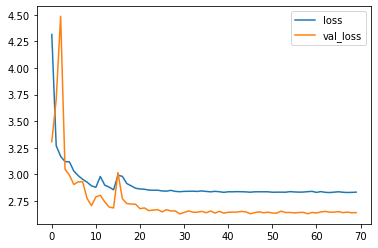

In [7]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()

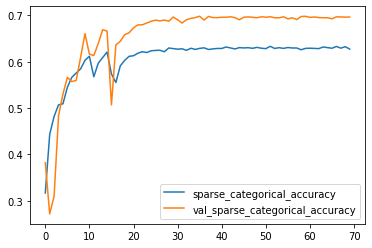

In [8]:
plt.plot(hist['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.legend()

In [9]:
Y_pred label_distrib = np.load('Y_pred label distrib.npy', allow_pickle=True)
print(Y_pred label_distrib)

SyntaxError: invalid syntax (3985109419.py, line 1)

In [10]:
confusion_matrix = np.load('confusion_matrix.npy', allow_pickle=True)
print(confusion_matrix)

[[58812   576   980  2324   199]
 [ 1580 42445  1965  5012 12034]
 [ 2699  1954 49779  6541  2036]
 [ 3041  1926  1773 54353  2295]
 [  767  5856   811  4504 50738]]


### XCEPTIONNET

In [ ]:
from cgi import test
import numpy as np
import os
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,LearningRateScheduler
from keras.backend.tensorflow_backend import set_session
import pickle
import math
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
channels = 3
IMG_SIZE = 299
DATADIR = "/home/mtech/2020/satyaki_ghosh/datasets/VISION"
CATEGORIES = [
    "D01_Samsung_GalaxyS3Mini",
    "D02_Apple_iPhone4s",
    "D03_Huawei_P9",
    "D04_LG_D290",
    "D05_Apple_iPhone5c"]
patches_per_photo = 100
img_per_model = 150
num_classes = 5

import sys 
import os


image_dim = (IMG_SIZE, IMG_SIZE, 3)

In [ ]:
# create generator
datagen = ImageDataGenerator()
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('./xceptionNet/data/train/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))
val_it = datagen.flow_from_directory('./xceptionNet/data/val/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))
test_it = datagen.flow_from_directory('./xceptionNet/data/test/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))

In [ ]:
from tensorflow.keras.models import load_model

model = tf.keras.applications.xception.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=image_dim,
    pooling=None,
    classes=5
    #classifier_activation='softmax'
)
opt = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9, decay = 0.0005)
model.compile(loss = "categorical_crossentropy", optimizer = opt , metrics = [tf.keras.metrics.CategoricalAccuracy()])                

# Save the weights using the `checkpoint_path` format
model.load_weights('xceptionNet/training_1/cp_0051.ckpt')

In [ ]:
def evaluate_model():
    loss, acc  = model.evaluate_generator(test_it)
    print("Accuracy: {:5.2f}%".format(100 * acc))


    # Checking label distributions
    Y_pred = model.predict_generator(test_it)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_test = test_it.classes
    print(f'Y_train label distrib: {np.unique(Y, return_counts=True)}')
    print(f'Y_test label distrib: {np.unique(Y_test, return_counts=True)}')
    y_pred_distrib = np.unique(Y_pred, return_counts=True)
    print(f'Y_pred_label distrib: {y_pred_distrib}')
    print(f'Number of different predicted labels: {np.shape(np.unique(Y_pred, return_counts=True))}')


    # Confusion Matrix
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
    print(f"Confusion matrix: \n{confusion_matrix(Y_test, Y_pred)}")
    print(f"Classification Report:\n {classification_report(Y_test, Y_pred)}")

    
# try getting GPU until it is done
ran = False
while ran == False:
    try:
        evaluate_model()
        ran = True
    except:
        print("")

### shallowCNN (see under separate folder for shallowCNN)

In [1]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,LearningRateScheduler
from keras.backend.tensorflow_backend import set_session
import math

IMG_SIZE=64

Using TensorFlow backend.


In [2]:
channels = 3
IMG_SIZE = 64
DATADIR = "/home/mtech/2020/satyaki_ghosh/datasets/VISION"
CATEGORIES = [
    "D01_Samsung_GalaxyS3Mini",
    "D02_Apple_iPhone4s",
    "D03_Huawei_P9",
    "D04_LG_D290",
    "D05_Apple_iPhone5c"]
patches_per_photo = 100
img_per_model = 150
num_classes = 5 


batch_size = 32
epochs = 80
image_dim = (IMG_SIZE, IMG_SIZE, 3)


# create generator
datagen = ImageDataGenerator(
                # featurewise_center=True,
                samplewise_center=True,
                rescale=0.0125
            )
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('./data/train/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))
val_it = datagen.flow_from_directory('./data/val/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))
test_it = datagen.flow_from_directory('./data/test/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
print(batchy.shape)

In [ ]:
model = Sequential()
# layer 1 
model.add(Conv2D(32, (4, 4), padding='valid', strides=(1,1), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 2
model.add(Conv2D(48, (5, 5), padding='valid', strides=(1,1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 3
model.add(Conv2D(64, (5, 5), padding='same', strides=(1,1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# # layer 4
model.add(Conv2D(128, (5, 5), strides=(1,1)))
# layer 5

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()